This notebook is about evaluating whether one-hot encoding variables like season and weekday improves model accuracy.

# Setup

## Basic Setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
import datetime
import random
import properscoring as ps

from scipy.stats import norm

import shap
import xgboost
import pydot
import graphviz
from pathlib import Path
import os

In [5]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [6]:
# Change Working Directory
os.chdir("..")
print(os.getcwd()) # print current working directory

c:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Probabilistic-Forecasting-of-Bicycle-Counts-in-Karlsruhe-with-Neural-Networks


In [7]:
plt.rcParams.update({'font.size': 14})

In [8]:
X_train = pd.read_pickle(r"data\X_train.pkl")
X_valid = pd.read_pickle(r"data\X_valid.pkl")
X_test = pd.read_pickle(r"data\X_test.pkl")

X_train_num = pd.read_pickle(r"data\X_train_num.pkl")
X_valid_num = pd.read_pickle(r"data\X_valid_num.pkl")
X_test_num = pd.read_pickle(r"data\X_test_num.pkl")

y_train = pd.read_pickle(r"data\y_train.pkl")
y_valid = pd.read_pickle(r"data\y_valid.pkl")
y_test = pd.read_pickle(r"data\y_test.pkl")


In [9]:
X_train['date'] =  pd.to_datetime(X_train['date'])
X_valid['date'] =  pd.to_datetime(X_valid['date'])
X_test['date'] =  pd.to_datetime(X_test['date'])

In [10]:
base_path_plots = Path("Figures\(09) Testing_One-hot_Encoding_Seasons_and_Weekdays")

<>:1: SyntaxWarning: invalid escape sequence '\('
<>:1: SyntaxWarning: invalid escape sequence '\('
C:\Users\aisti\AppData\Local\Temp\ipykernel_43544\2788593568.py:1: SyntaxWarning: invalid escape sequence '\('
  base_path_plots = Path("Figures\(09) Testing_One-hot_Encoding_Seasons_and_Weekdays")


In [11]:
X_train.head()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,2012-04-25,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,No Holiday,0,No Holiday,0,0,1,0,2
1,2012-04-26,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,No Holiday,0,No Holiday,0,0,1,0,3
2,2012-04-27,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,No Holiday,0,No Holiday,0,0,1,0,4
3,2012-04-28,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,No Holiday,0,No Holiday,0,0,0,0,5
4,2012-04-29,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,No Holiday,0,No Holiday,0,0,0,0,6


In [12]:
X_valid.tail()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
359,2022-12-27,-1.064496,0.559862,-0.258711,0.499927,1.588705,-0.397192,-0.353265,-0.408308,0,weihnachtsferien,1,No Holiday,0,1,1,3,1
360,2022-12-28,-0.478837,-0.529141,1.087091,0.637500,2.515281,-0.397192,-0.823509,0.563344,0,weihnachtsferien,1,No Holiday,0,1,1,3,2
361,2022-12-29,-0.104279,-0.185464,2.276769,0.637500,2.110005,0.143383,-0.913940,1.739554,1,weihnachtsferien,1,No Holiday,0,1,1,3,3
362,2022-12-30,-0.691404,1.127138,-0.674006,0.265242,0.451524,0.169125,-0.508807,1.739554,1,weihnachtsferien,1,No Holiday,0,1,1,3,4
363,2022-12-31,0.541485,-0.727895,1.564836,0.597037,2.650446,-0.397192,-0.201340,1.458287,0,weihnachtsferien,1,No Holiday,0,1,0,3,5


In [13]:
X_train_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,0,6


In [14]:
y_test.head()

0    1160.0
1    2996.0
2    3635.0
3    3265.0
4    3751.0
Name: bike_count, dtype: float64

In [15]:
X_train.shape, X_valid.shape, X_test.shape

((3161, 18), (364, 18), (390, 18))

In [16]:
X_train_num.shape, X_valid_num.shape, X_test_num.shape

((3161, 15), (364, 15), (390, 15))

In [17]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [18]:
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [19]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [20]:
X_train.isna().sum()

date                        0
temperature                 0
humidity                    0
windspeed                   0
wind_direction              0
visibility                  0
precipitation               0
sun                         0
windspeed_max               0
precip_indic                0
school_holiday              0
school_holiday_indicator    0
public_holiday              0
public_holiday_indicator    0
holiday_indicator           0
is_workday                  0
season                      0
day_of_week                 0
dtype: int64

In [21]:
X_train_num.isna().sum()

temperature                 0
humidity                    0
windspeed                   0
wind_direction              0
visibility                  0
precipitation               0
sun                         0
windspeed_max               0
precip_indic                0
school_holiday_indicator    0
public_holiday_indicator    0
holiday_indicator           0
is_workday                  0
season                      0
day_of_week                 0
dtype: int64

In [22]:
X_train.dtypes

date                        datetime64[ns]
temperature                        float64
humidity                           float64
windspeed                          float64
wind_direction                     float64
visibility                         float64
precipitation                      float64
sun                                float64
windspeed_max                      float64
precip_indic                         int64
school_holiday                      object
school_holiday_indicator             int64
public_holiday                      object
public_holiday_indicator             int64
holiday_indicator                    int64
is_workday                           int64
season                               int64
day_of_week                          int64
dtype: object

In [23]:
X_train.describe()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
count,3161,3.161000e+03,3.161000e+03,3.161000e+03,3.161000e+03,3.161000e+03,3.161000e+03,3.161000e+03,3.161000e+03,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000
mean,2016-10-06 22:22:03.378677504,4.450726e-16,-3.281849e-16,4.832859e-17,1.719599e-16,-1.078964e-16,3.708939e-17,4.720467e-17,-1.185736e-16,0.401772,0.232521,0.033534,0.248972,0.684910,1.492249,3.001898
min,2012-04-25 00:00:00,-2.660948e+00,-3.112937e+00,-1.513961e+00,-2.348657e+00,-2.003308e+00,-3.971923e-01,-1.094803e+00,-1.891355e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014-06-24 00:00:00,-7.932892e-01,-7.651612e-01,-7.364558e-01,-6.573103e-01,-8.238480e-01,-3.971923e-01,-9.899026e-01,-6.384357e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,2016-08-22 00:00:00,-9.270793e-04,9.610389e-02,-2.056287e-01,4.432786e-01,3.399334e-02,-3.971923e-01,-2.085744e-01,-1.014702e-01,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000
75%,2018-11-02 00:00:00,7.907021e-01,7.793190e-01,4.969366e-01,7.507961e-01,7.585809e-01,-1.140338e-01,8.585175e-01,5.122046e-01,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,5.000000
max,2022-01-01 00:00:00,2.566737e+00,1.918011e+00,4.952762e+00,2.361217e+00,2.407294e+00,1.461021e+01,2.193287e+00,5.523883e+00,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,6.000000
std,NaN,1.000158e+00,1.000158e+00,1.000158e+00,1.000158e+00,1.000158e+00,1.000158e+00,1.000158e+00,1.000158e+00,0.490334,0.422506,0.180054,0.432486,0.464625,1.101504,2.001106


## Functions

In [24]:
def add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, col_name):
    
    X_train_num[col_name] = X_train[col_name]
    X_valid_num[col_name] = X_valid[col_name]
    X_test_num[col_name] = X_test[col_name]
    
    return X_train_num, X_valid_num, X_test_num

In [25]:
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [26]:
def crps_normal_cost_function_v2(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]

    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [27]:
def predict_and_calculate_mean_crps(model, X_test = X_test_num, y_test = y_test, print_predicted_mean_std = False):
    """Make predictions on test data and calculate mean CRPS.

    Args:
        model: Trained model
        X_test: Test data
        y_test: True values
        print_predicted_mean_std: Boolean to print predicted mean and std

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
     
    predicted_mean_std = model.predict(X_test)
    if print_predicted_mean_std:
        print(predicted_mean_std)
    
    predicted_mean = predicted_mean_std[:, 0]
    predicted_std = predicted_mean_std[:, 1]
    mean_crps = np.mean(ps.crps_gaussian(y_test, mu=predicted_mean, sig=predicted_std))
    print(f"\nMean CRPS: { mean_crps }")


    return mean_crps, predicted_mean_std

In [28]:
def compile_and_fit_model(model, X_train = X_train_num, y_train = y_train, X_valid = X_valid_num, y_valid = y_valid,  pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10):
    """Compile and fit a model on training data.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        model: Trained model
    """

    #print some information about the model
    print('Model information:\n\nCallbacks: EarlyStopping (patience: ' + str(pat) + '), Learning Rate (Reduce on Plateau, patience: ' + str(pat) + ')\nBatch size: ' + str(batch_size) + '\nEpochs: ' + str(epochs) + '\n')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=pat, 
                                                      restore_best_weights=True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience = pat,
                                                     min_lr=0 )
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

    return model, history

In [29]:
def plot_loss(history):
    """Plot training and validation loss.

    Args:
        history: History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [30]:
def process_model(model, X_train = X_train_num, y_train = y_train, X_valid = X_valid_num, y_valid = y_valid,  X_test = X_test_num, y_test = y_test, pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10, print_predicted_mean_std = False, plot_loss_flag = True):
    """Compile, fit and evaluate a model.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        X_test: Test data
        y_test: Test targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size
        print_predicted_mean_std: Boolean to print predicted mean and std
"""

    model, history = compile_and_fit_model(model, X_train, y_train, X_valid, y_valid,  pat, lr, loss_function, epochs, batch_size)

    mean_crps, predicted_mean_std = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std)

    if plot_loss_flag:
        plot_loss(history)

    return model, mean_crps, history, predicted_mean_std

## Baseline Model

In [31]:
baseline_model = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
baseline_model, baseline_model_history = compile_and_fit_model(baseline_model, X_train_num, y_train, X_valid_num, y_valid, pat=5, lr=1e-3, loss_function=crps_normal_cost_function_v2, epochs=200, batch_size=10)

Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1891.3763 - val_loss: 594.2470 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 743.9127 - val_loss: 511.1655 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 683.1649 - val_loss: 626.1987 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 655.8345 - val_loss: 507.3594 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 663.2435 - val_loss: 676.3101 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 627.5218 - val_loss: 505.3523 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 646.6865 - val_loss: 485.9657 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 579.4690 - val_loss: 506.7748 - learning_rate: 0.0010
Epoch 9/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 567.8941 - val_loss: 473.3210 

In [33]:
baseline_model_mean_crps, baseline_model_predicted_mean_std = predict_and_calculate_mean_crps(baseline_model, X_test_num, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Mean CRPS: 324.19347669189744


## One-Hot Encoding the Season Column

In [34]:
#One-hot encoding the season column
season_encoder = OneHotEncoder(sparse_output=False)

# Fit the encoder on the training data and transform the training, validation, and test data
season_train_encoded = season_encoder.fit_transform(X_train_num[['season']])
season_valid_encoded = season_encoder.transform(X_valid_num[['season']])
seasons_test_encoded = season_encoder.transform(X_test_num[['season']])

# Convert the encoded columns to DataFrame
seasons_train_encoded_df = pd.DataFrame(season_train_encoded, columns=season_encoder.get_feature_names_out(['season']))
seasons_valid_encoded_df = pd.DataFrame(season_valid_encoded, columns=season_encoder.get_feature_names_out(['season']))
seasons_test_encoded_df = pd.DataFrame(seasons_test_encoded, columns=season_encoder.get_feature_names_out(['season']))

# Concatenate the encoded columns back to the original dataframes
X_train_num = pd.concat([X_train_num.reset_index(drop=True), seasons_train_encoded_df], axis=1)
X_valid_num = pd.concat([X_valid_num.reset_index(drop=True), seasons_valid_encoded_df], axis=1)
X_test_num = pd.concat([X_test_num.reset_index(drop=True), seasons_test_encoded_df], axis=1)

# Drop the original 'seasons' column
X_train_num.drop(columns=['season'], inplace=True)
X_valid_num.drop(columns=['season'], inplace=True)
X_test_num.drop(columns=['season'], inplace=True)

In [35]:
season_encoder.categories_[0].tolist()

[0, 1, 2, 3]

In [36]:
X_train_num.tail()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,day_of_week,season_0,season_1,season_2,season_3
3156,-0.335171,0.737912,1.546101,0.564667,0.519395,2.872001,-1.094803,2.915764,1,1,0,1,1,1,0.0,0.0,0.0,1.0
3157,-0.389412,1.284484,1.183889,0.807444,0.235983,0.297833,-1.094803,0.972461,1,1,0,1,1,2,0.0,0.0,0.0,1.0
3158,0.183053,1.135419,1.211992,0.734611,1.887147,-0.319967,-1.087569,0.435495,1,1,0,1,1,3,0.0,0.0,0.0,1.0
3159,-0.530879,1.574333,-0.599065,0.548482,-0.621426,-0.397192,-0.190488,-0.331598,0,1,0,1,1,4,0.0,0.0,0.0,1.0
3160,-0.453182,1.052605,-1.151750,0.427093,-0.402028,-0.397192,0.178472,-1.252111,0,1,1,1,0,5,0.0,0.0,0.0,1.0


In [37]:
# Define a dictionary with the old column names as keys and the new column names as values
new_column_names = {

    'season_0': 'spring',
    'season_1': 'summer',
    'season_2': 'autumn',
    'season_3': 'winter'
}

# Rename the columns
X_train_num.rename(columns=new_column_names, inplace=True)
X_valid_num.rename(columns=new_column_names, inplace=True)
X_test_num.rename(columns=new_column_names, inplace=True)


X_test_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter
0,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,1,1,1,0,6,0.0,0.0,0.0,1.0
1,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,1,0,1,1,0,0.0,0.0,0.0,1.0
2,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,1,0,1,1,1,0.0,0.0,0.0,1.0
3,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,1,0,1,1,2,0.0,0.0,0.0,1.0
4,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,1,0,1,1,3,0.0,0.0,0.0,1.0


## Training a first baseline model

In [38]:
baseline_model1 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
baseline_model1, baseline_model_history1 = compile_and_fit_model(baseline_model1, X_train_num, y_train, X_valid_num, y_valid, pat=5, lr=1e-3, loss_function=crps_normal_cost_function_v2, epochs=200, batch_size=10)

Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200


317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1852.6078 - val_loss: 564.9194 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 675.2150 - val_loss: 496.6674 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 663.0599 - val_loss: 574.1597 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 605.3055 - val_loss: 487.5807 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 607.0587 - val_loss: 543.7960 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 575.1013 - val_loss: 448.1498 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 549.1385 - val_loss: 497.0010 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 545.2167 - val_loss: 399.5000 - learning_rate: 0.0010
Epoch 9/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 519.3049 - val_loss: 490.3714 

In [40]:
baseline_model_mean_crps1, baseline_model_predicted_mean_std1 = predict_and_calculate_mean_crps(baseline_model1, X_test_num, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Mean CRPS: 317.39279248504516


## One-Hot Encoding the weekday column

In [41]:
#One-hot encoding the season column
weekday_encoder = OneHotEncoder(sparse_output=False)

# Fit the encoder on the training data and transform the training, validation, and test data
weekday_train_encoded = weekday_encoder.fit_transform(X_train_num[['day_of_week']])
weekday_valid_encoded = weekday_encoder.transform(X_valid_num[['day_of_week']])
weekday_test_encoded = weekday_encoder.transform(X_test_num[['day_of_week']])

# Convert the encoded columns to DataFrame
weekday_train_encoded_df = pd.DataFrame(weekday_train_encoded, columns=weekday_encoder.get_feature_names_out(['day_of_week']))
weekday_valid_encoded_df = pd.DataFrame(weekday_valid_encoded, columns=weekday_encoder.get_feature_names_out(['day_of_week']))
weekday_test_encoded_df = pd.DataFrame(weekday_test_encoded, columns=weekday_encoder.get_feature_names_out(['day_of_week']))

# Concatenate the encoded columns back to the original dataframes
X_train_num = pd.concat([X_train_num.reset_index(drop=True), weekday_train_encoded_df], axis=1)
X_valid_num = pd.concat([X_valid_num.reset_index(drop=True), weekday_valid_encoded_df], axis=1)
X_test_num = pd.concat([X_test_num.reset_index(drop=True), weekday_test_encoded_df], axis=1)

# Drop the original 'weekday' column
X_train_num.drop(columns=['day_of_week'], inplace=True)
X_valid_num.drop(columns=['day_of_week'], inplace=True)
X_test_num.drop(columns=['day_of_week'], inplace=True)

In [42]:
weekday_encoder.categories_[0].tolist()

[0, 1, 2, 3, 4, 5, 6]

In [43]:
X_valid_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,...,summer,autumn,winter,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,-0.598314,0.671661,0.219033,0.532297,0.294482,-0.397192,-0.711374,0.767902,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.121137,-0.023976,2.264278,0.783166,1.320575,-0.345709,-1.065865,2.123101,1,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.392344,1.301047,1.527366,0.993573,-0.958363,10.002447,-1.094803,1.432717,1,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-1.117271,-0.044680,1.805269,0.969295,1.270619,-0.165517,-0.479869,1.125879,1,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.243345,0.998776,-0.005788,0.483741,-0.028579,-0.397192,-0.913940,-0.485017,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [44]:
# Define a dictionary with the old column names as keys and the new column names as values
new_column_names = {
    'day_of_week_0': 'Monday',
    'day_of_week_1': 'Tuesday',
    'day_of_week_2': 'Wednesday',
    'day_of_week_3': 'Thursday',
    'day_of_week_4': 'Friday',
    'day_of_week_5': 'Saturday',
    'day_of_week_6': 'Sunday',
}

# Rename the columns
X_train_num.rename(columns=new_column_names, inplace=True)
X_valid_num.rename(columns=new_column_names, inplace=True)
X_test_num.rename(columns=new_column_names, inplace=True)


X_test_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,...,summer,autumn,winter,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Training a  Second Baseline Model

In [45]:
baseline_model2 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
baseline_model2, baseline_model_history2 = compile_and_fit_model(baseline_model2, X_train_num, y_train, X_valid_num, y_valid, pat=5, lr=1e-3, loss_function=crps_normal_cost_function_v2, epochs=200, batch_size=10)

Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200


317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1719.6731 - val_loss: 442.4721 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 571.1743 - val_loss: 443.3478 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 551.9497 - val_loss: 429.3109 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 526.1707 - val_loss: 523.4324 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 499.3972 - val_loss: 463.8685 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 489.0692 - val_loss: 538.6479 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 495.2527 - val_loss: 705.5483 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 518.0100 - val_loss: 411.8428 - learning_rate: 0.0010
Epoch 9/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 488.0338 - val_loss: 477.9081 

In [47]:
baseline_model_mean_crps2, baseline_model_predicted_mean_std2 = predict_and_calculate_mean_crps(baseline_model2, X_test_num, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Mean CRPS: 359.3411441953155


## Removing the one hot encoded weekday columns

In [48]:
X_train_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,...,summer,autumn,winter,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
X_train_num.columns

Index(['temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
       'precipitation', 'sun', 'windspeed_max', 'precip_indic',
       'school_holiday_indicator', 'public_holiday_indicator',
       'holiday_indicator', 'is_workday', 'spring', 'summer', 'autumn',
       'winter', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday'],
      dtype='object')

In [50]:
X_train.head()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,2012-04-25,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,No Holiday,0,No Holiday,0,0,1,0,2
1,2012-04-26,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,No Holiday,0,No Holiday,0,0,1,0,3
2,2012-04-27,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,No Holiday,0,No Holiday,0,0,1,0,4
3,2012-04-28,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,No Holiday,0,No Holiday,0,0,0,0,5
4,2012-04-29,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,No Holiday,0,No Holiday,0,0,0,0,6


In [51]:
X_valid.columns

Index(['date', 'temperature', 'humidity', 'windspeed', 'wind_direction',
       'visibility', 'precipitation', 'sun', 'windspeed_max', 'precip_indic',
       'school_holiday', 'school_holiday_indicator', 'public_holiday',
       'public_holiday_indicator', 'holiday_indicator', 'is_workday', 'season',
       'day_of_week'],
      dtype='object')

In [52]:
# Extract the weekday columns
weekday_columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
X_train_weekdays = X_train_num[weekday_columns]
X_valid_weekdays = X_valid_num[weekday_columns]
X_test_weekdays = X_test_num[weekday_columns]

# Remove the weekday columns from X_train_num
X_train_num = X_train_num.drop(columns=weekday_columns)
X_valid_num = X_valid_num.drop(columns=weekday_columns)
X_test_num = X_test_num.drop(columns=weekday_columns)

X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'day_of_week')

In [53]:
X_valid_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,spring,summer,autumn,winter,day_of_week
0,-0.598314,0.671661,0.219033,0.532297,0.294482,-0.397192,-0.711374,0.767902,0,1,0,1,0,0.0,0.0,0.0,1.0,6
1,-0.121137,-0.023976,2.264278,0.783166,1.320575,-0.345709,-1.065865,2.123101,1,1,0,1,1,0.0,0.0,0.0,1.0,0
2,-0.392344,1.301047,1.527366,0.993573,-0.958363,10.002447,-1.094803,1.432717,1,1,0,1,1,0.0,0.0,0.0,1.0,1
3,-1.117271,-0.044680,1.805269,0.969295,1.270619,-0.165517,-0.479869,1.125879,1,1,0,1,1,0.0,0.0,0.0,1.0,2
4,-1.243345,0.998776,-0.005788,0.483741,-0.028579,-0.397192,-0.913940,-0.485017,0,1,1,1,0,0.0,0.0,0.0,1.0,3


In [54]:
X_test_num.columns

Index(['temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
       'precipitation', 'sun', 'windspeed_max', 'precip_indic',
       'school_holiday_indicator', 'public_holiday_indicator',
       'holiday_indicator', 'is_workday', 'spring', 'summer', 'autumn',
       'winter', 'day_of_week'],
      dtype='object')

# Feature Selection

## Permutation Importance

In [55]:
def crps_scorer(estimator, X, y):
    """
    A wrapper for crps_normal_cost_function to work with Scikit-learn's scoring API.
    
    Args:
        estimator: Trained model with a `predict` method.
        X: Features (numpy array or pandas DataFrame).
        y: True target values (numpy array or pandas Series).

    Returns:
        Scalar score (negative CRPS for minimization).
    """
    # Generate predictions using the model
    y_pred = estimator.predict(X)  # Assuming [mean, std] output
    # Ensure y is a NumPy array
    y_true = y.to_numpy() if hasattr(y, "to_numpy") else y
    # Call the CRPS function (use tensor=False to avoid TensorFlow tensors)
    crps_values = crps_normal_cost_function(y_true, y_pred, tensor=False)
    # Return the mean CRPS as a negative value for minimization
    return -np.mean(crps_values)  # Negating for Scikit-learn's convention

### Baseline Model

In [56]:
# Extract the season columns
season_columns = ['spring', 'summer', 'autumn', 'winter']

X_train_season = X_train_num[season_columns]
X_valid_season = X_valid_num[season_columns]
X_test_season = X_test_num[season_columns]

In [57]:
X_train_num = X_train_num.drop(columns=season_columns)
X_valid_num = X_valid_num.drop(columns=season_columns)
X_test_num = X_test_num.drop(columns=season_columns)

X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'season')

X_test_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,day_of_week,season
0,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,1,1,1,0,6,3
1,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,1,0,1,1,0,3
2,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,1,0,1,1,1,3
3,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,1,0,1,1,2,3
4,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,1,0,1,1,3,3


In [58]:
result_baseline_model = permutation_importance(baseline_model, X_test_num, y_test, scoring=crps_scorer)
importances_baseline_model = result_baseline_model.importances_mean
importance_stds_baseline_model = result_baseline_model.importances_std

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [59]:
feature_names = X_test_num.columns

importance_df_baseline_model = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_baseline_model,
    'Std': importance_stds_baseline_model
}).sort_values(by='Importance', ascending=False)

print(importance_df_baseline_model)

                     Feature  Importance        Std
0                temperature  281.548431  11.051016
13               day_of_week  278.736511   9.697991
12                is_workday  126.033081   9.607354
10  public_holiday_indicator   82.608086  11.389844
5              precipitation   69.423004  14.019833
6                        sun   44.497368   7.872673
8               precip_indic   21.763439   5.928422
9   school_holiday_indicator   21.684759   8.382740
4                 visibility   18.944616   4.703081
7              windspeed_max   14.968854   3.856040
2                  windspeed    9.145246   2.952499
1                   humidity    8.109265   4.519645
11         holiday_indicator    4.069977   6.555491
14                    season    0.870178   1.027393
3             wind_direction    0.285681   2.640545


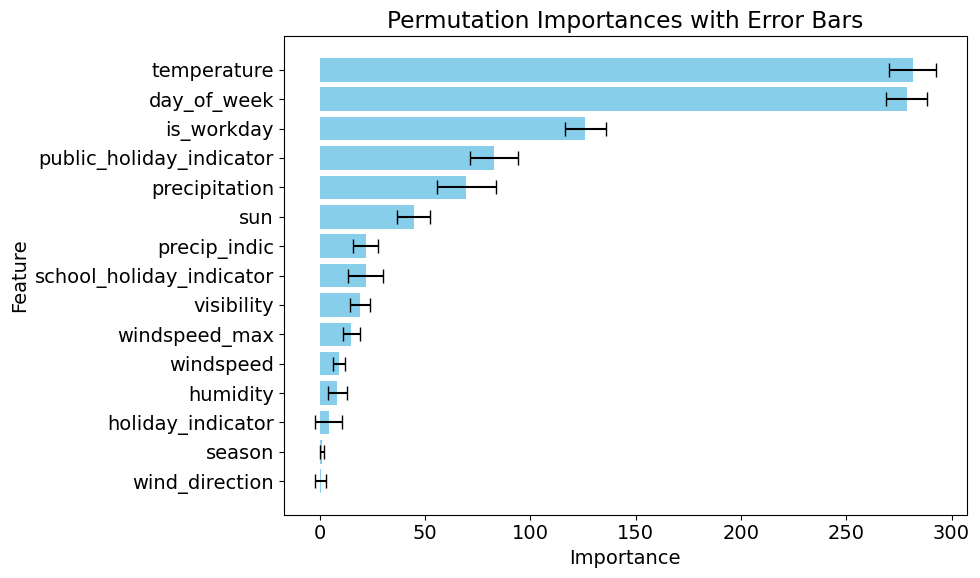

In [60]:
# Plot with error bars
feature_importance = plt.figure(figsize=(10, 6))
plt.barh( importance_df_baseline_model['Feature'], importance_df_baseline_model['Importance'], xerr=importance_df_baseline_model['Std'], color='skyblue', capsize=5 )
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances with Error Bars')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
feature_importance.figure.savefig(base_path_plots / "permutation_importance_baseline_model.png")

### Baseline Model 1

Only the season data is one-hot encoded, not the weekday data

In [61]:
X_train_num = pd.concat([X_train_num.reset_index(drop=True), X_train_season.reset_index(drop=True)], axis=1)
X_valid_num = pd.concat([X_valid_num.reset_index(drop=True), X_valid_season.reset_index(drop=True)], axis=1)
X_test_num = pd.concat([X_test_num.reset_index(drop=True), X_test_season.reset_index(drop=True)], axis=1)

X_train_num = X_train_num.drop(columns=['season'])
X_valid_num = X_valid_num.drop(columns=['season'])
X_test_num = X_test_num.drop(columns=['season'])

X_train_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,2,1.0,0.0,0.0,0.0
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,3,1.0,0.0,0.0,0.0
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,4,1.0,0.0,0.0,0.0
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,5,1.0,0.0,0.0,0.0
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,6,1.0,0.0,0.0,0.0


In [62]:
result_baseline_model1 = permutation_importance(baseline_model1, X_test_num, y_test, scoring=crps_scorer)
importances_baseline_model1 = result_baseline_model1.importances_mean
importance_stds_baseline_model1 = result_baseline_model1.importances_std

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [63]:
feature_names1 = X_test_num.columns

importance_df_baseline_model1 = pd.DataFrame({
    'Feature': feature_names1,
    'Importance': importances_baseline_model1,
    'Std': importance_stds_baseline_model1
}).sort_values(by='Importance', ascending=False)

print(importance_df_baseline_model1)

                     Feature  Importance        Std
16                    autumn  427.247894  23.383848
15                    summer  406.507660  37.223980
13               day_of_week  364.841980  18.543812
14                    spring  356.430267  20.944376
17                    winter  257.996735  22.027773
0                temperature  235.122406  17.481979
12                is_workday  203.702179  24.306547
5              precipitation  113.484573   8.547504
10  public_holiday_indicator   97.811668   4.530267
11         holiday_indicator   52.672798   3.683205
9   school_holiday_indicator   37.450642   3.369831
2                  windspeed   33.769524   4.174751
8               precip_indic   24.302856   4.207077
6                        sun   16.573523   4.745532
1                   humidity   12.813635   0.884861
7              windspeed_max    7.820539   3.953677
4                 visibility    4.885303   2.655721
3             wind_direction    2.411420   2.867019


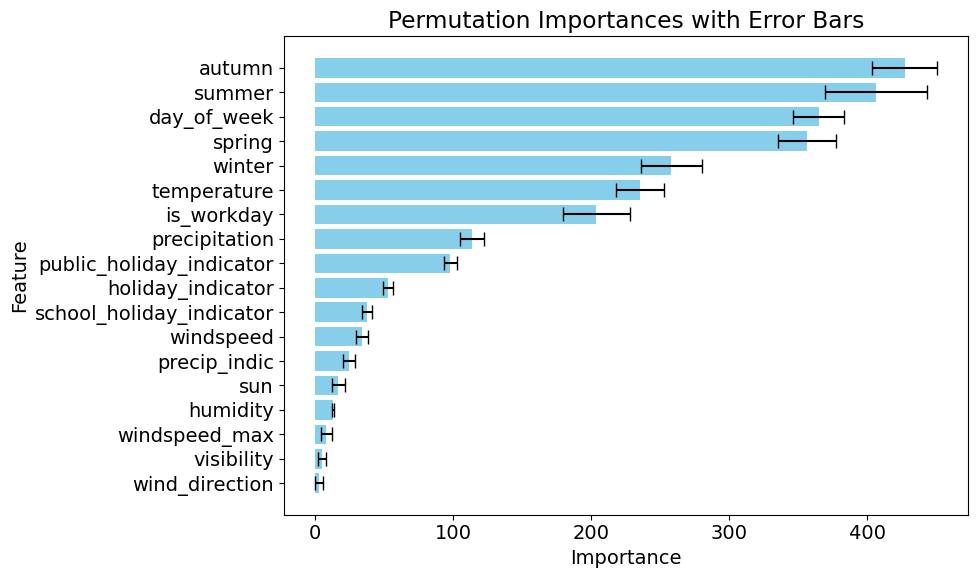

In [64]:
# Plot with error bars
feature_importance1 = plt.figure(figsize=(10, 6))
plt.barh( importance_df_baseline_model1['Feature'], importance_df_baseline_model1['Importance'], xerr=importance_df_baseline_model1['Std'], color='skyblue', capsize=5 )
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances with Error Bars')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_importance1.figure.savefig(base_path_plots / "permutation_importance_baseline_model1.png")

### Baseline Model 2

Weekday and season data are one hot encoded

In [65]:

X_train_num = pd.concat([X_train_num.reset_index(drop=True), X_train_weekdays.reset_index(drop=True)], axis=1)
X_valid_num = pd.concat([X_valid_num.reset_index(drop=True), X_valid_weekdays.reset_index(drop=True)], axis=1)
X_test_num = pd.concat([X_test_num.reset_index(drop=True), X_test_weekdays.reset_index(drop=True)], axis=1)

X_train_num = X_train_num.drop(columns=['day_of_week'])
X_valid_num = X_valid_num.drop(columns=['day_of_week'])
X_test_num = X_test_num.drop(columns=['day_of_week'])

X_train_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,...,summer,autumn,winter,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [66]:
result_baseline_model2 = permutation_importance(baseline_model2, X_test_num, y_test, scoring=crps_scorer)
importances_baseline_model2 = result_baseline_model2.importances_mean
importance_stds_baseline_model2 = result_baseline_model2.importances_std

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [67]:
feature_names2 = X_test_num.columns

importance_df_baseline_model2 = pd.DataFrame({
    'Feature': feature_names2,
    'Importance': importances_baseline_model2,
    'Std': importance_stds_baseline_model2
}).sort_values(by='Importance', ascending=False)

print(importance_df_baseline_model2)

                     Feature  Importance        Std
12                is_workday  598.897400  15.122253
0                temperature  206.444824  14.761827
22                  Saturday  131.748520  10.732035
23                    Sunday   97.981216   3.743926
15                    autumn   94.514168   9.535057
14                    summer   91.724930  10.134445
13                    spring   73.086624   5.030540
5              precipitation   67.306839   7.296348
11         holiday_indicator   64.326408   4.872683
19                 Wednesday   52.458172   1.161563
20                  Thursday   48.794415   3.673924
16                    winter   46.922192   4.122347
10  public_holiday_indicator   44.757042   4.515622
9   school_holiday_indicator   39.780037   4.671421
18                   Tuesday   35.234138   3.677927
21                    Friday   29.716669   3.427972
17                    Monday   29.513611   5.563973
6                        sun   18.552404   8.050500
2           

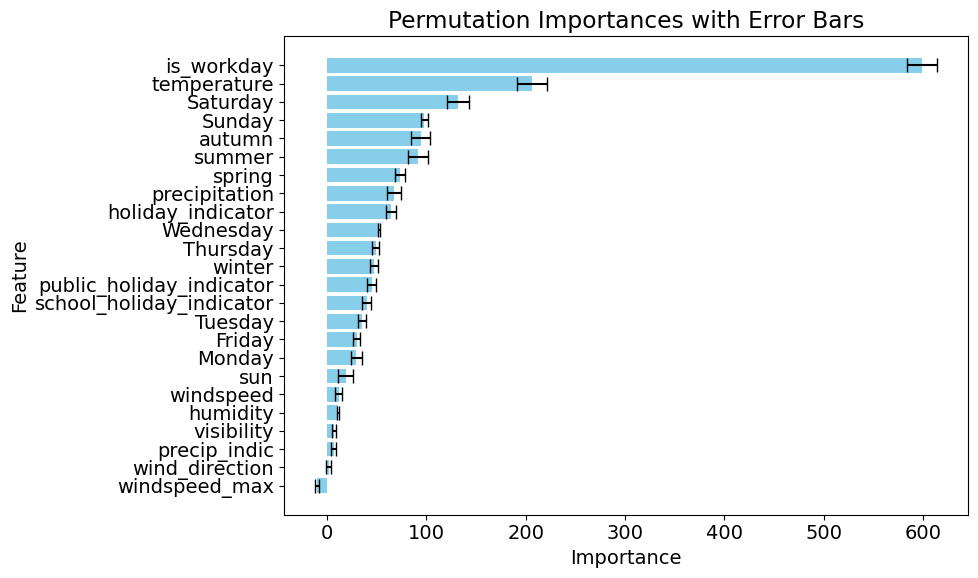

In [68]:
# Plot with error bars
feature_importance2 = plt.figure(figsize=(10, 6))
plt.barh( importance_df_baseline_model2['Feature'], importance_df_baseline_model2['Importance'], xerr=importance_df_baseline_model2['Std'], color='skyblue', capsize=5 )
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances with Error Bars')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_importance2.figure.savefig(base_path_plots / "permutation_importance_baseline_model2.png")

## Shap

In [69]:
shap.initjs()

### Baseline Model

In [70]:
# Remove the weekday columns
X_train_num = X_train_num.drop(columns=weekday_columns)
X_valid_num = X_valid_num.drop(columns=weekday_columns)
X_test_num = X_test_num.drop(columns=weekday_columns)

X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'day_of_week')

In [71]:
X_train_num = X_train_num.drop(columns=season_columns)
X_valid_num = X_valid_num.drop(columns=season_columns)
X_test_num = X_test_num.drop(columns=season_columns)

X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'season')

X_test_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,day_of_week,season
0,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,1,1,1,0,6,3
1,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,1,0,1,1,0,3
2,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,1,0,1,1,1,3
3,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,1,0,1,1,2,3
4,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,1,0,1,1,3,3


In [72]:
background_data = shap.sample(X_train_num, 100)

In [73]:
explainer_sample = shap.KernelExplainer(baseline_model.predict, background_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [74]:
shap_values = explainer_sample.shap_values(X_test_num, nsamples=100)

  0%|          | 0/390 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━

In [75]:
shap_values_mu = shap_values[:, :, 0]
shap_values_mu_explanation = shap.Explanation(values=shap_values_mu, data=X_test_num)
shap_values_mu_explanation

.values =
array([[   91.49995173,   -50.73156483,     0.        , ...,
         -379.6019831 , -1045.80849815,   -59.5511342 ],
       [   29.437285  ,   -19.25902829,    35.15461052, ...,
          232.72897236,   767.3269428 ,    46.56565274],
       [ -333.50953369,   193.38189445,    74.24613505, ...,
          243.76169416,  1236.48758959,   -55.47127355],
       ...,
       [ -136.5805413 ,    15.39277575,   -94.19292906, ...,
          247.77313306,   837.42353667,   -56.13255937],
       [  150.07478455,     0.        ,  -217.79462032, ...,
          276.82259996,   583.6762252 ,   -64.43286186],
       [  -49.92183065,    56.68841583,     9.73948739, ...,
          260.88508761,   187.68987647,     7.36881114]])

.data =
     temperature  humidity  windspeed  wind_direction  visibility  \
0       0.156666 -0.574689  -0.146301        0.435186    1.740197   
1      -0.267002  0.406656  -0.196261        0.386631    1.259373   
2      -0.832871  1.040183  -1.011237        0.313798

In [76]:
shap_values_mu_explanation.feature_names = X_train_num.columns.tolist()

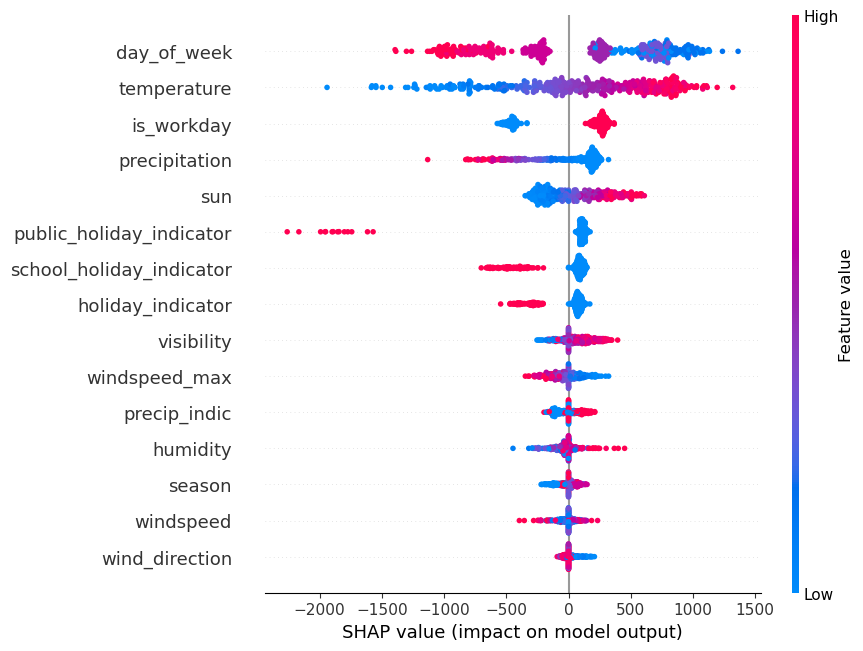

<Figure size 640x480 with 0 Axes>

In [77]:
beeswarm_plot = shap.plots.beeswarm(shap_values_mu_explanation, max_display=15)
plt.tight_layout()
plt.show()
plt.close()

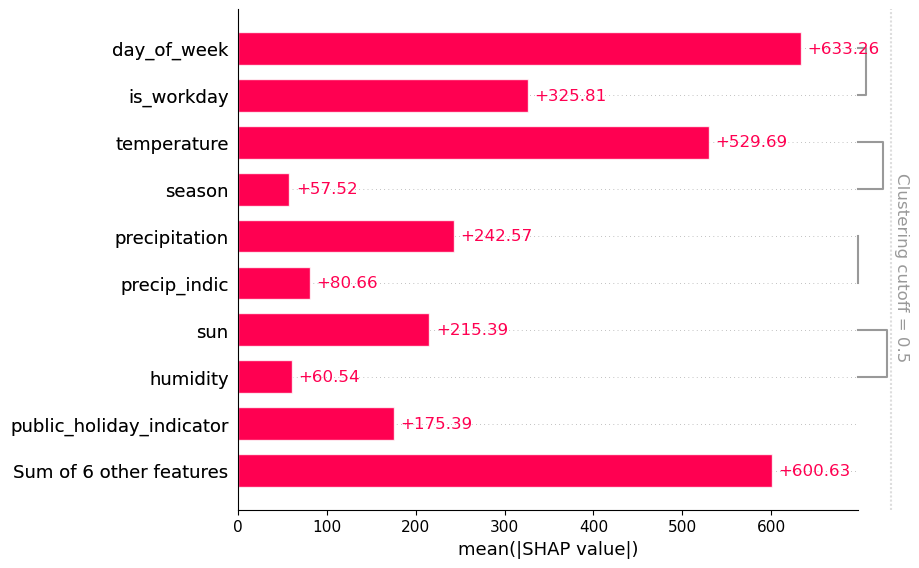

<Figure size 640x480 with 0 Axes>

In [78]:
clustering = shap.utils.hclust(X_train_num, y_train)
shap.plots.bar(shap_values_mu_explanation, clustering=clustering)
plt.tight_layout()
plt.show()
plt.close()

### Baseline Model 1
only season data one-hot encoded

In [79]:
X_train_num = pd.concat([X_train_num.reset_index(drop=True), X_train_season.reset_index(drop=True)], axis=1)
X_valid_num = pd.concat([X_valid_num.reset_index(drop=True), X_valid_season.reset_index(drop=True)], axis=1)
X_test_num = pd.concat([X_test_num.reset_index(drop=True), X_test_season.reset_index(drop=True)], axis=1)

X_train_num = X_train_num.drop(columns=['season'])
X_valid_num = X_valid_num.drop(columns=['season'])
X_test_num = X_test_num.drop(columns=['season'])

X_train_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,2,1.0,0.0,0.0,0.0
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,3,1.0,0.0,0.0,0.0
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,4,1.0,0.0,0.0,0.0
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,5,1.0,0.0,0.0,0.0
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,6,1.0,0.0,0.0,0.0


#### Calculating the Shap values

In [80]:
background_data1 = shap.sample(X_train_num, 100)

In [81]:
explainer_sample1 = shap.KernelExplainer(baseline_model1.predict, background_data1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [82]:
shap_values1 = explainer_sample1.shap_values(X_test_num, nsamples=100)

  0%|          | 0/390 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
313/313 ━━━━━━

In [83]:
shap_values_mu1 = shap_values1[:, :, 0]
shap_values_mu_explanation1 = shap.Explanation(values=shap_values_mu1, data=X_test_num)
shap_values_mu_explanation1

.values =
array([[ 101.72111706,  -50.97011607,    0.        , ..., -307.29393762,
        -504.49377513,  481.24970703],
       [  47.74499099,  -29.11145613,   39.9666073 , ..., -358.95925583,
        -536.08049152,  365.32699767],
       [-231.52431471,  -29.65763251,  146.53164545, ..., -333.53704795,
        -578.03994819,  479.10883027],
       ...,
       [ -41.65548052,   35.71079574, -270.6424021 , ..., -386.85763332,
        -451.09246274,  693.37831413],
       [ 169.30524143,   34.84236993, -358.21198848, ..., -375.93144242,
        -445.65392537,  722.49692114],
       [   0.        ,  -12.87795318,   18.61242846, ..., -369.2377251 ,
        -504.2001697 ,  816.48248753]])

.data =
     temperature  humidity  windspeed  wind_direction  visibility  \
0       0.156666 -0.574689  -0.146301        0.435186    1.740197   
1      -0.267002  0.406656  -0.196261        0.386631    1.259373   
2      -0.832871  1.040183  -1.011237        0.313798    0.940566   
3      -0.452449  0.

In [84]:
print(shap_values_mu_explanation1.feature_names)

None


In [85]:
shap_values_mu_explanation1.feature_names = X_train_num.columns.tolist()

In [86]:
type(shap_values_mu_explanation1)

shap._explanation.Explanation

In [87]:
shap_values_mu_explanation1.shape

(390, 18)

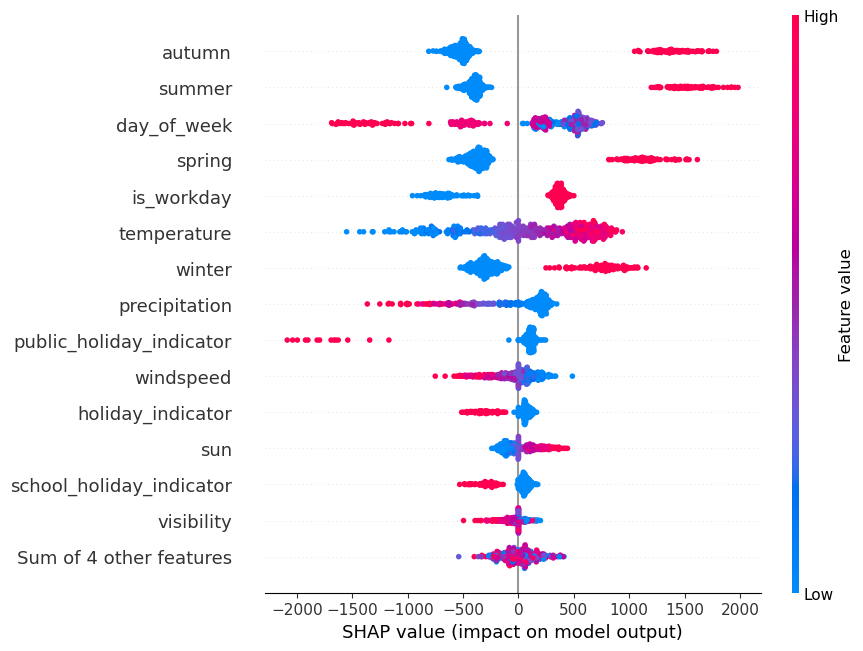

<Figure size 640x480 with 0 Axes>

In [88]:
beeswarm_plot1 = shap.plots.beeswarm(shap_values_mu_explanation1, max_display=15)
plt.tight_layout()
plt.show()
plt.close()

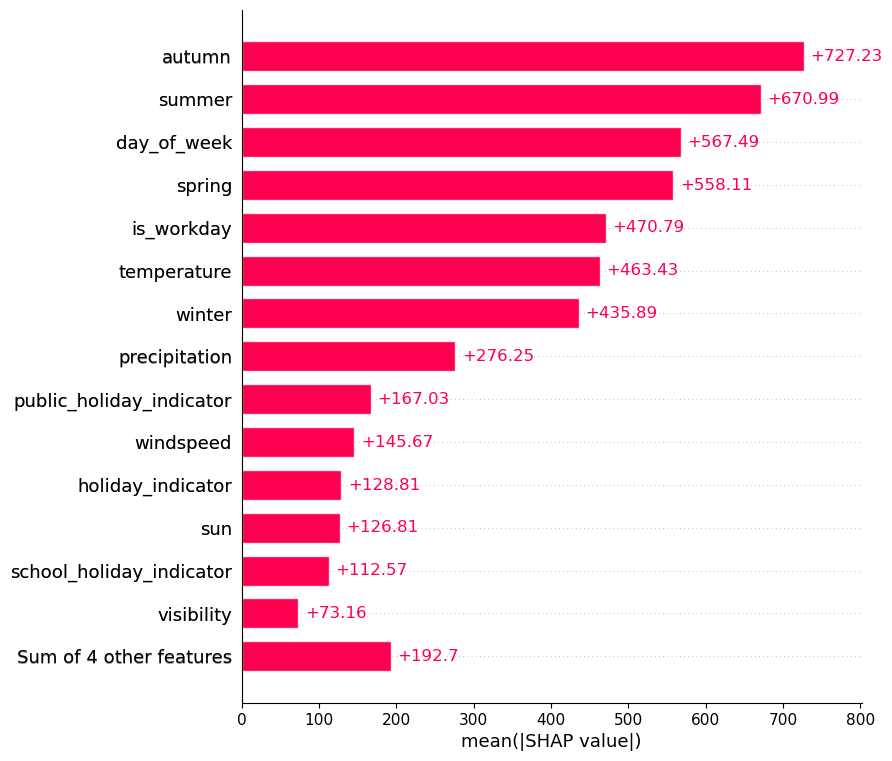

<Figure size 640x480 with 0 Axes>

In [89]:
shap.plots.bar(shap_values_mu_explanation1, max_display=15 )
plt.tight_layout()
plt.show()
plt.close()

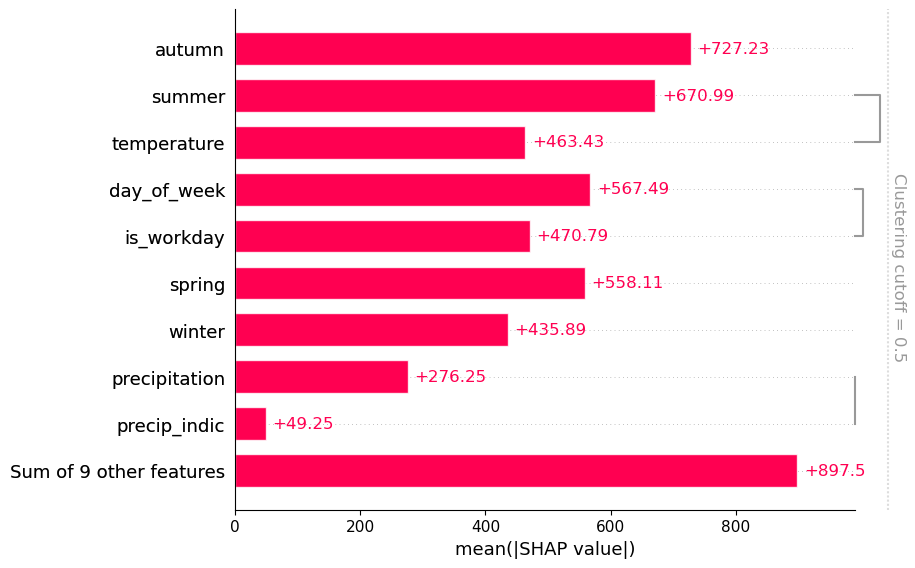

<Figure size 640x480 with 0 Axes>

In [90]:
clustering1 = shap.utils.hclust(X_train_num, y_train)
shap.plots.bar(shap_values_mu_explanation1, clustering=clustering1)
plt.tight_layout()
plt.show()
plt.close()

### Baseline Model 2

#### Adding the one-hot encoded weekday data

In [91]:
X_train_num = pd.concat([X_train_num.reset_index(drop=True), X_train_weekdays.reset_index(drop=True)], axis=1)
X_valid_num = pd.concat([X_valid_num.reset_index(drop=True), X_valid_weekdays.reset_index(drop=True)], axis=1)
X_test_num = pd.concat([X_test_num.reset_index(drop=True), X_test_weekdays.reset_index(drop=True)], axis=1)

X_train_num = X_train_num.drop(columns=['day_of_week'])
X_valid_num = X_valid_num.drop(columns=['day_of_week'])
X_test_num = X_test_num.drop(columns=['day_of_week'])

X_train_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,...,summer,autumn,winter,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Calculating the Shap values

In [92]:
background_data2 = shap.sample(X_train_num, 100)

In [93]:
explainer_sample2 = shap.KernelExplainer(baseline_model2.predict, background_data2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [94]:
shap_values2 = explainer_sample2.shap_values(X_test_num, nsamples=100)

  0%|          | 0/390 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━

In [95]:
shap_values_mu2 = shap_values2[:, :, 0]
shap_values_mu_explanation2 = shap.Explanation(values=shap_values_mu2, data=X_test_num)
shap_values_mu_explanation2

.values =
array([[   0.        ,    0.        ,    0.        , ...,  -81.60736095,
        -117.29651312, -426.82397887],
       [ -32.11217864,  -43.02299436,   31.78113899, ..., -103.35636234,
        -197.21891767,   50.98852842],
       [-306.18328625,   64.67396027,   61.41661006, ..., -126.75610243,
        -178.60928194,   93.86829196],
       ...,
       [-147.36511574,  -21.36123388, -177.03307079, ...,  -75.58098445,
        -194.08009802,  118.96695243],
       [ 113.42753834,    0.        , -180.28342473, ...,  -95.58682416,
        -179.32339115,  148.3018753 ],
       [ -43.29473155,  -21.17536217,   21.19210544, ..., -110.13445677,
        -177.27011911,   96.47277645]])

.data =
     temperature  humidity  windspeed  wind_direction  visibility  \
0       0.156666 -0.574689  -0.146301        0.435186    1.740197   
1      -0.267002  0.406656  -0.196261        0.386631    1.259373   
2      -0.832871  1.040183  -1.011237        0.313798    0.940566   
3      -0.452449  0.

In [96]:
shap_values_mu_explanation2.feature_names = X_train_num.columns.tolist()

In [97]:
shap_values_mu_explanation2.shape

(390, 24)

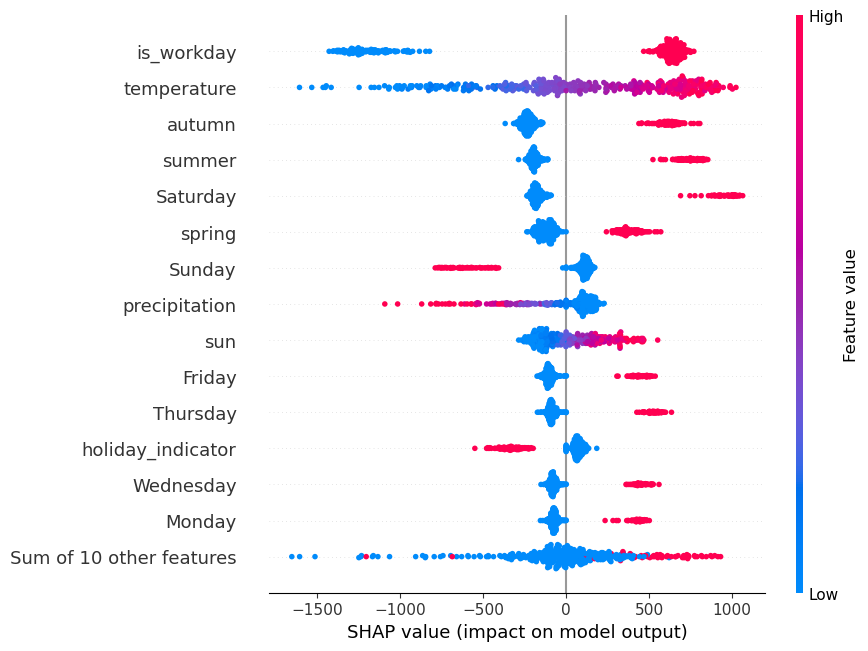

<Figure size 640x480 with 0 Axes>

In [98]:
beeswarm_plot2 = shap.plots.beeswarm(shap_values_mu_explanation2, max_display=15)
plt.tight_layout()
plt.show()
plt.close()

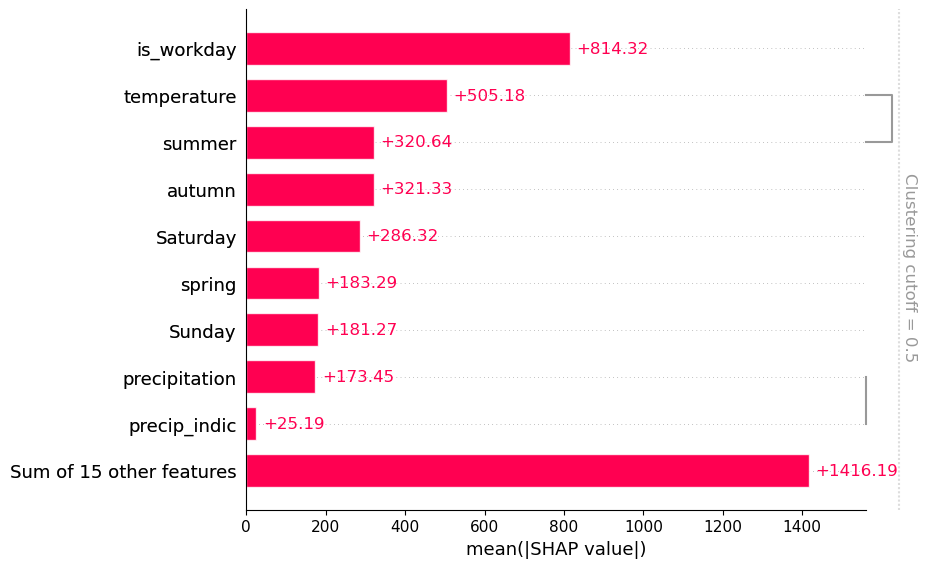

<Figure size 640x480 with 0 Axes>

In [99]:
clustering2 = shap.utils.hclust(X_train_num, y_train)
shap.plots.bar(shap_values_mu_explanation2, clustering=clustering2)
plt.tight_layout()
plt.show()
plt.close()